### MNIST Digit Classification Example
MNIST data source was taken from ... \
https://www.kaggle.com/datasets/oddrationale/mnist-in-csv <br />
https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/ <br />
https://pjreddie.com/projects/mnist-in-csv/

The mnist_train.csv file contains the 60,000 training examples and labels. The mnist_test.csv contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255). 

The format is \
label, pix-11, pix-12, pix-13, ...

In [95]:
import numpy as np 
import csv

def image_loader(filename, image, label): 
    with open(filename) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for id, line in enumerate(csv_reader):
            i, j = 0, 0
            label[id] = line[0]

            i, j, count = (0, 0, 0)
            for pixel in line[1:]:
                i = int(count/28)
                j = count%28
                count += 1
                image[id, i, j] = pixel

train_images = np.empty((60000,28,28))
train_labels = np.empty(60000)

test_images = np.empty((10000,28,28))
test_labels = np.empty(10000)

image_loader('mnist_train.csv', train_images, train_labels)
image_loader('mnist_test.csv', test_images, test_labels)

(10000,) (10000, 28, 28)
(60000,) (60000, 28, 28)
5.0


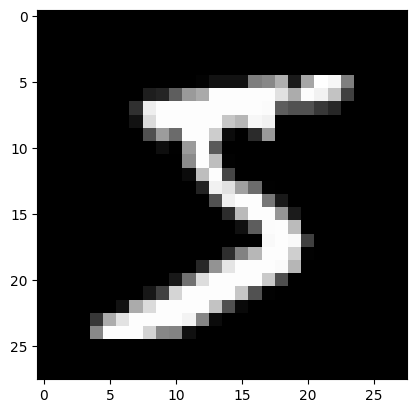

In [96]:
#test data 
import matplotlib.pyplot as plt

print(test_labels.shape, test_images.shape)
print(train_labels.shape, train_images.shape)

# plt.imshow(test_images[1998], cmap='gray', interpolation='none')
plt.imshow(train_images[0], cmap='gray', interpolation='none')
print(train_labels[0])


#### Normalization

In [97]:
#normalization 
import torch
x_train = torch.tensor(train_images.reshape(60000,28*28), dtype=torch.float32)
mean = torch.mean(x_train).item()
std = torch.std(x_train).item()
print(f'mean = {mean:0.2f}, std = {std:0.2f}')

x_test = torch.tensor(test_images.reshape(10000,28*28), dtype=torch.float32)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

mean = 33.32, std = 78.57


#### One-hot encode 

In [98]:
#one-hot endcode
y_train = torch.zeros((60000, 10))
y_test = torch.zeros((10000, 10))

for index, value in enumerate(train_labels):
    y_train[index, int(value)] = 1

for index, value in enumerate(test_labels):
    y_test[index, int(value)] = 1

#### Fully connected network

input = 28*28 pixels = 784 linear inputs\
layer1 - fully connects 784 inputs to 25 neurons, activatation function = tanh\
layer2 - fully connects 25 outputs from layer1 to 10 neurons, activation function = sigmoid 

In [118]:
#neural network model
import torch.nn as nn

class Mnist(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(784,25),
            nn.Tanh(),
            nn.Linear(25,10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear(x)
    
def data_gen(x_train, y_train):
    index = list(range(len(x_train)))
    np.random.shuffle(index)
    for i in index:
        yield x_train[i], y_train[i]

m = Mnist()
y = m(x_train[0])
print(y)
print(y_train[0])

print(y.data)
_, indice = torch.max(y.data, 0)
print(indice.item())
# print(y.argmax().item(), y_train[0].argmax().item())

tensor([0.4752, 0.4598, 0.4717, 0.4128, 0.5320, 0.5579, 0.6189, 0.6523, 0.5305,
        0.5826], grad_fn=<SigmoidBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0.4752, 0.4598, 0.4717, 0.4128, 0.5320, 0.5579, 0.6189, 0.6523, 0.5305,
        0.5826])
7


#### Training

In [100]:
#training
EPOCHS = 20
LEARNING_RATE = 0.01

loss_fn = torch.nn.MSELoss(reduction='sum')

torch.manual_seed(3)
mnist = Mnist()

#initialize weight and bias
for module in mnist.modules():
    if isinstance(module, nn.Linear):
        nn.init.uniform_(module.weight, a=-0.1, b=0.1)
        nn.init.constant_(module.bias, 0.0)

print(mnist)
print('\n' + '-'*100 +'\n')
for param in mnist.parameters():
    print(param)
print('\n' + '-'*100 +'\n')

for epoch in range(EPOCHS):
    #train data 
    correct_train_results = 0
    for x, y in data_gen(x_train, y_train):
        y_pred = mnist(x)
        loss = loss_fn(y_pred, y)

        if y_pred.argmax() == y.argmax():
            correct_train_results += 1

        mnist.zero_grad()

        loss.backward()

        with torch.no_grad():
            for param in mnist.parameters():
                param -= LEARNING_RATE * param.grad

    #validate with test data
    correct_test_results = 0
    for x, y in data_gen(x_test, y_test):
        y_pred = mnist(x)
        loss = loss_fn(y_pred, y)
    
        if y_pred.argmax() == y.argmax():
            correct_test_results += 1

    train_acc = correct_train_results/len(x_train)
    test_acc = correct_test_results/len(x_test)
    print('epoch no:', epoch, 'train_acc: ', f'{train_acc:6.4f}', 'test_acc', f'{test_acc:6.4f}')

Mnist(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

----------------------------------------------------------------------------------------------------

Parameter containing:
tensor([[-0.0455, -0.0809, -0.0828,  ...,  0.0031, -0.0396,  0.0880],
        [ 0.0806,  0.0200, -0.0025,  ..., -0.0826, -0.0461,  0.0198],
        [ 0.0318, -0.0005,  0.0114,  ..., -0.0606,  0.0202,  0.0560],
        ...,
        [-0.0571,  0.0362, -0.0722,  ..., -0.0969, -0.0465,  0.0318],
        [-0.0517,  0.0255, -0.0736,  ...,  0.0565, -0.0730, -0.0518],
        [-0.0600,  0.0450, -0.0017,  ..., -0.0373,  0.0506, -0.0571]],
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], requires_grad=True)
Parameter containing:
tensor([[-0.0077, -0.0539, -0.0246,  0.0

KeyboardInterrupt: 

In [120]:
y = torch.rand(10)
x = y.argmax()
print(x)

x = torch.tensor([1,0,1,1])
y = torch.tensor([0,1,1,0])

(x == y).sum()

tensor(3)


tensor(1)